### TODO
* copy in other file
* find unused code
* doublecheck zeropoints
* doublecheck catalogue
* check folder - a temp data folder
* catalogue referencing later is not with variablized
* update planck cosmology

In [1]:
catalogue = "gds/jades/phot/hlsp_jades_jwst_nircam_goods-s-deep_photometry_v1.0_catalog_large_withSpec.fits"
cat_out_name = "gds_jwst_nircam_large_withSpec"
templates = [
    "EMlines"
]

In [2]:
import eazy, os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from math import ceil, floor
from copy import deepcopy as copy

from astropy import units as u
from astropy.cosmology import Planck18
from astropy.io import fits
from astropy.table import Table, join, hstack
from astropy.visualization import ZScaleInterval as zs
from astroquery.mast import Observations as obs
from IPython.utils import io
from matplotlib.transforms import Affine2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import eazy_routines as ez
import helper_module as hmod

if not os.path.exists('templates'):
    eazy.symlink_eazy_inputs()

cosmo = Planck18

if "temp" not in os.listdir():
    os.mkdir("temp")

In [3]:
# log all camera filters
flt = eazy.filters.FilterFile()

filts_nircam = {
        'F090W': 363,
        'F115W': 364,
        'F150W': 365,
        'F182M': 370,
        'F200W': 366,
        'F210M': 371,
        'F277W': 375,
        'F335M': 381,
        'F356W': 376,
        'F410M': 383,
        'F430M': 384,
        'F444W': 358,
        'F460M': 385,
        'F480M': 386
}

filts_HST = {
        'F105W': 202,
        'F125W': 203,
        'F140W': 204,
        'F160W': 205,
        'F435W': 233,
        'F606W': 214,
        'F775W': 216,
        'F814W': 239,
        'F850LP': 240
}

filts = {**filts_nircam, **filts_HST}

mw_reddening = ez.get_atten_dict(filts)#!is used?

# get zeropoints
zps = [1.0]*len(filts)#!should be evaluated if this is correct

In [4]:
#=== load data
#inname = "hlsp_jades_jwst_nircam_goods-s-deep_photometry_v1.0_catalog.fits"
inname = catalogue.split('/')[-1]
inpath = os.path.join(os.getenv('astrodata'), catalogue)

# print the meta info
with fits.open(inpath) as hdul:
    print(hdul.info())

# load photometry table
tab = Table.read(inpath, hdu=6)
tab_redshifts = Table.read(inpath, hdu=9)

#=== make EAZY table

# load fluxes
# CIRC1: 0.10 arcsec aperture (see README)
ext = '_CIRC1'
cols_dummy = hmod.get_matches(ext, tab.columns, exclude='_ei')
cols_f = np.sort(hmod.get_matches(ext, cols_dummy, exclude='_e'))
cols_fe = np.sort(hmod.get_matches('_e', cols_dummy))
cols_fluxes = list(np.vstack([cols_f, cols_fe]).T.flatten())
cols = list(np.insert(cols_fluxes, 0, ['ID', 'RA', 'DEC', 'z_spec']))
del cols_dummy

tab = join(tab, tab_redshifts['ID', 'z_spec'], join_type='inner', keys='ID')
tab_out = tab[cols]

# convert from nJy to uJy
# and apply MW reddening
keys = np.array(list(mw_reddening.keys()))
for c in cols_fluxes:
    tab_out[c].unit = u.nJy
    tab_out[c] = tab_out[c].to(u.uJy)
    
    # apply MW reddening
    matches = hmod.get_matches(keys, c, get_idxs=True)
    key = keys[np.int32(matches[:,0])][0]
    tab_out[c] *= mw_reddening[key]
del c, keys, key, matches
    
# rename columns
for c in cols_f:
    cnew = c.replace(ext, '_flux')
    tab_out.rename_column(c, cnew)
del c, cnew

for c in cols_fe:
    cnew = c.replace(ext+'_e', '_err')
    tab_out.rename_column(c, cnew)
del c, cnew

#=== apply MW reddening
#atten_dict = ez.get_atten_dict(filts_eazyres, filts_str)
#degr_image_sig *= atten_dict[filt] / 100. # uJy

# save EAZY table
tab_out.write(f'temp/{cat_out_name}.fits', format='fits', overwrite=True)

Filename: /home/ubuntu-compute/Desktop/astrodata/gds/jades/phot/hlsp_jades_jwst_nircam_goods-s-deep_photometry_v1.0_catalog_large_withSpec.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      13   ()      
  1  FILTERS       1 BinTableHDU     33   23R x 12C   [6A, E, E, E, E, E, E, E, E, E, E, E]   
  2  FLAG          1 BinTableHDU    161   1429R x 75C   [J, D, D, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, E, E]   
  3  SIZE          1 BinTableHDU    100   1429R x 43C   [J, D, D, E, D, D, D, D, J, J, J, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   
  4  CIRC          1 BinTableHDU    856   1429R x 423C   [J, D, D, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E,

None


In [5]:
runTime = int(time.time())

In [6]:
#=== set up paths for eazy

# catalog paths
cat_path = f'temp/{cat_out_name}.fits'
keys_id = ['ID id', 'RA ra', 'DEC dec', 'z_spec z_spec']

# template names and paths
ftempl_strs = [
    'EMextreme',
    'EMlines',
    'fsps_45k_0.3removed',
    'fsps_45k',
    'fsps_60k',
    'carnall_sfhz_13',
    'corr_sfhz_13',
    'blue_sfhz_13',
    'eazy_v1.1_lines.spectra', 
    'eazy_v1.3.spectra',
    'br07_default.spectra',
    #'pegase.spectra',
    'pegase13.spectra',
    #'cww+kin.spectra'
    ]
templ_paths = [f"templates/{e}.param" for e in ftempl_strs]
out_names = [f for f in ftempl_strs]
out_paths = [f"eazy-output/{f}_{runTime}" for f in out_names]
#paths = np.array([templ_paths, out_paths]).T

In [7]:
##################### RUN EAZY #####################

# iterate over tempalte sets
for tpath, opath, oname in zip(templ_paths, out_paths, out_names):
    
    params = {"cat_path": cat_path,
              "templ_path": tpath,
              "out_path": opath,
              "FIX_ZSPEC": 'n',
              "USE_ZSPEC_FOR_REST": 'n',
              "Z_MAX": 12.0,
              "H0": cosmo.H0,
              "OMEGA_M": cosmo.Om0,
              "OMEGA_L": cosmo.Ode0,
              "CATALOG_FORMAT": 'fits'}
    
    # write eazy config files
    filt_num, fnames = ez.write_config(f'{cat_out_name}_{oname}', filts, zps, keys_id,
                                       out_path=opath)

    # run eazy
    #idx = np.array([0])
    idx = None
    zout, hdu = ez.run_eazy(params, fnames, n_proc=-1, idx=idx)

Read default param file: /home/ubuntu-compute/miniconda3/envs/astro/lib/python3.11/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: temp/gds_jwst_nircam_large_withSpec.fits
   >>> NOBJ = 1429
F090W_flux F090W_err (363): jwst_nircam_f090w
F115W_flux F115W_err (364): jwst_nircam_f115w
F150W_flux F150W_err (365): jwst_nircam_f150w
F182M_flux F182M_err (370): jwst_nircam_f182m
F200W_flux F200W_err (366): jwst_nircam_f200w
F210M_flux F210M_err (371): jwst_nircam_f210m
F277W_flux F277W_err (375): jwst_nircam_f277w
F335M_flux F335M_err (381): jwst_nircam_f335m
F356W_flux F356W_err (376): jwst_nircam_f356w
F410M_flux F410M_err (383): jwst_nircam_f410m
F430M_flux F430M_err (384): jwst_nircam_f430m
F444W_flux F444W_err (358): jwst_niriss_f444w
F460M_flux F460M_err (385): jwst_nircam_f460m
F480M_flux F480M_err (386): jwst_nircam_f480m
F105W_flux F105W_err (202): hst/wfc3/IR/f105w.dat
F125W_flux F125W_err (203): hst/wfc3/IR/f125w.dat
F140W_flux F140W_err (204): hst/wfc3/IR/f140w.dat


/home/ubuntu-compute/miniconda3/envs/astro/lib/python3.11/site-packages/eazy/photoz.py:1326: RuntimeWarning: invalid value encountered in log10
  self.prior_mag_cat += -2.5*np.log10(np.squeeze(self.fnu[:,ix]))
  0%|          | 0/40 [00:00<?, ?it/s]

In [7]:
#find latest runTime in folder:
runTime = int(np.sort([int(f.split('_')[-1]) for f in os.listdir('eazy-output')])[-1])
outpaths = 'eazy-output/{ftempl}_{runTime}/' + cat_out_name + '.zout.fits'

In [8]:
##################### READ EAZY OUTPUT #####################
rawSets = {}
for ftempl in ftempl_strs:
    outpath = outpaths.format(ftempl=ftempl, runTime=runTime)
    if f'{ftempl}_{runTime}' not in os.listdir('eazy-output'):
        continue
    if cat_out_name + '.zout.fits' not in os.listdir(outpath.rsplit('/', 1)[0]):
        continue
    rawSets[ftempl] = Table.read(outpath)

In [9]:
##################### READ REDSHIFT OUTPUT #####################
redshiftSets = {}
for key in rawSets.keys():
    tbl = rawSets[key]
    data = {}
    data['ID'] = tbl['id']
    data['z_spec'] = tbl['z_spec']
    data['z_phot'] = tbl['z_phot']
    data['z_phot_chi2'] = tbl['z_phot_chi2']
    data['z_phot_risk'] = tbl['z_phot_risk']
    redshiftSets[key] = Table(
        data = [d for d in data.values()],
        names = [d for d in data.keys()]
    )

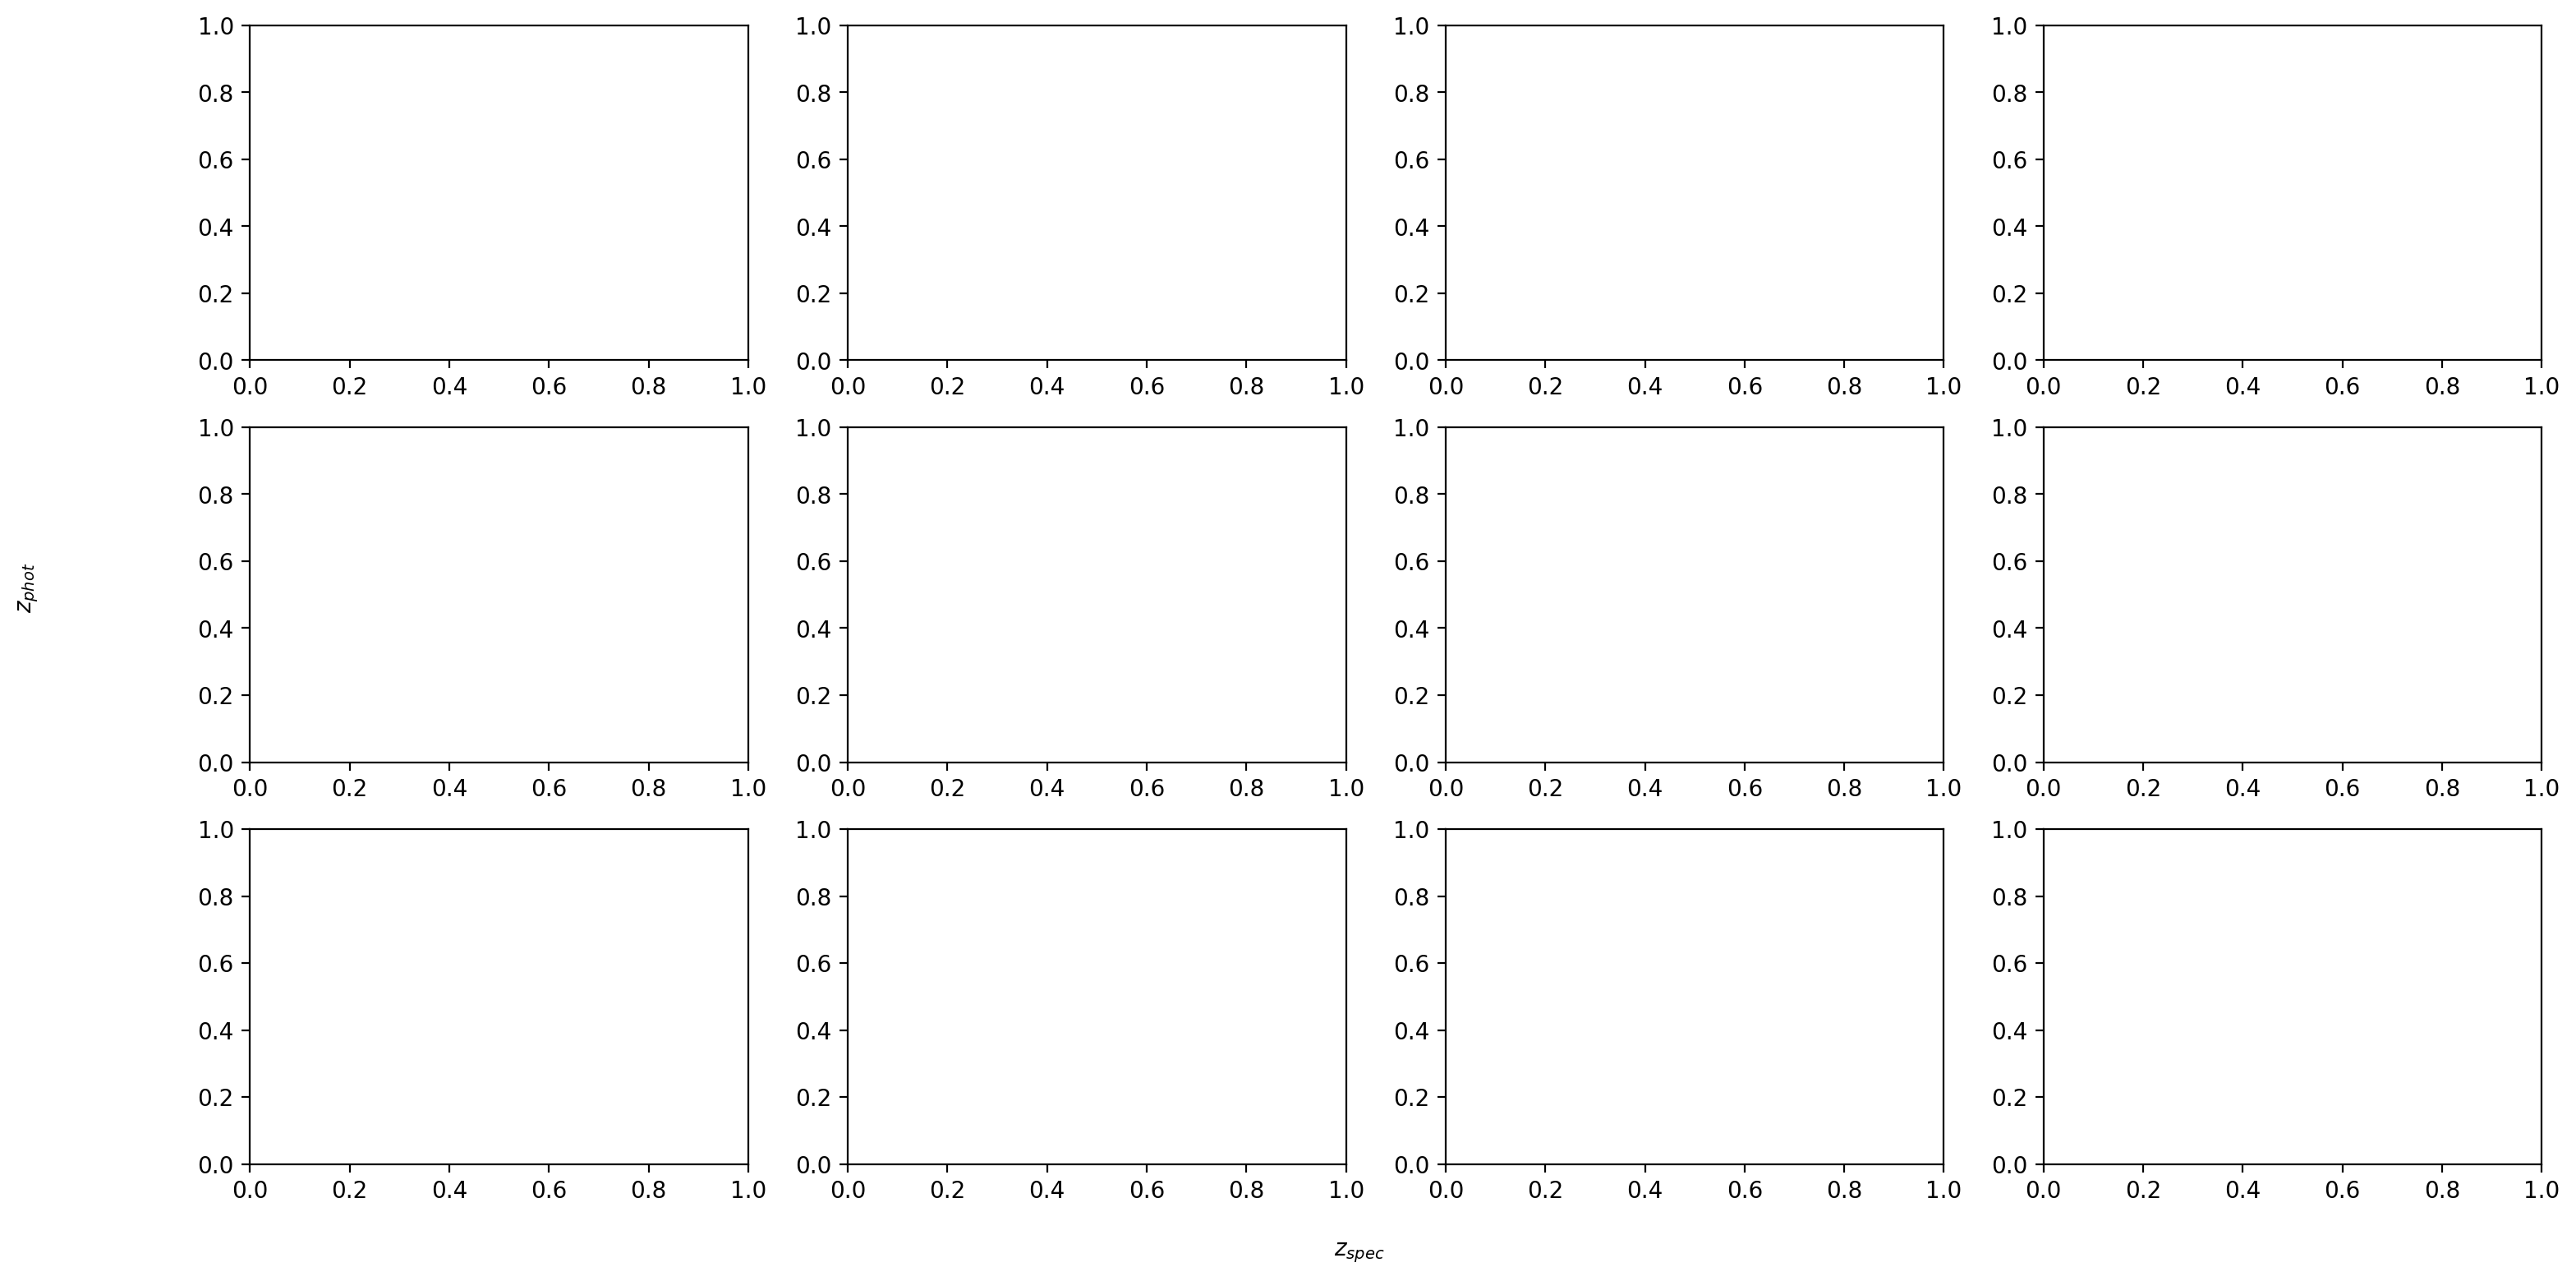

In [11]:
##################### PLOT REDSHIFT OUTPUT #####################

mosTiling = 3
mosaicLen = ceil(len(ftempl_strs) / mosTiling)
figMos, axsMos = plt.subplots(mosTiling, mosaicLen, figsize=(mosTiling*mosaicLen*1.5, 3*mosTiling), dpi=200)
#transpose and flatten
axsMos = axsMos.T
axsMos = axsMos.flatten()

for i, ftempl in enumerate(redshiftSets.keys()):
    redshiftTbl = redshiftSets[ftempl]

    #outpath = outpaths.format(ftempl=ftempl, runTime=runTime)

    """#find light intensities
    ids = df_props['id'].values
    filtTab = Table.read(inpath, hdu=4)
    #get values ending with "CIRC1"
    pointIDs = filtTab['ID']
    filtTab = filtTab[[f for f in filtTab.colnames if f.endswith('CIRC1')]]
    #get dictionary version of table
    filtTab = filtTab.to_pandas()
    keys = filtTab.keys()
    fluxes = np.array([np.array(filtTab[key]) for key in keys]).T
    pointIntensities = np.sum(fluxes, axis=1)"""

    """#clear up bad ids and make simular sort
    for j,id in list(enumerate(ids))[::-1]:
        if id not in df_props['id'].values:
            pointIntensities = np.delete(pointIntensities, j)
            ids = np.delete(ids, j)
    #sort pointIntensities and ids to match df_props
    pointIntensities = pointIntensities[np.argsort(ids)]
    ids = np.sort(ids)
    antiSort = np.argsort(df_props['id'].values)
    sort = np.argsort(antiSort)
    pointIntensities = pointIntensities[sort]
    ids = ids[sort]"""
    #Remove sub zero and nan
    mask_cur = (redshiftTbl['z_spec'] > 0) & (~np.isnan(redshiftTbl['z_spec'])) & (~np.isnan(redshiftTbl['z_phot']))
    x = np.array(redshiftTbl['z_spec'])
    y = np.array(redshiftTbl['z_phot'])
    above = y > x + (1 + x) * 0.15 # outliers
    below = y < x - (1 + x) * 0.15
    outlier = above | below
    mask_in = mask_cur & (~outlier)
    x = x[mask_cur]
    y = y[mask_cur]
    #mask_out = mask_cur & outlier
    chi2_fit = redshiftTbl['z_phot_chi2'][mask_cur]/len(redshiftTbl.keys())#!new
    avgchi2_fit = np.mean(chi2_fit)
    medchi2_fit = np.median(chi2_fit)
    
    avgchi2_fit_in = redshiftTbl['z_phot_chi2'][mask_in]/len(x)#!new
    #c = np.log10(pointIntensities[mask_cur])*((x/(1+x))**2)#!quilitative reshift scaling
    c = np.ones(len(x))

    #calculate chi2 with linear regression of x and y
    chi2 = np.sum((y - x)**2/1)/len(x)#/len(x)#!dunno what to put for sigma

    xmin, xmax = np.c_[[x, y]].min(), np.c_[[x, y]].max()

    axsMos[i].scatter(x, y, s=2.0, c=c, cmap='Greys')
    #axsMos[i].scatter(x, y, s=2.0)
    axsMos[i].plot([xmin, xmax], [xmin, xmax], c='k', ls='--', lw=0.5)
    
    dict_stat = hmod.phot_spec_zs_stats(y, x)

    #annotate in bottom right
    annotAnchor = np.array((1.025, 0.6))
    axsMos[i].set_title(f'{ftempl}', fontsize=10)
    ay = 0
    for j, (k, val) in enumerate(dict_stat.items()):
        if k == 'eta': tex = '\\'
        else: tex = ''
        axsMos[i].annotate(rf'${tex}{k}$: {val:.3f}', annotAnchor - np.array((0.05, (ay:=ay+0.06))),
                            xycoords='axes fraction', fontsize=8, ha='right')
    axsMos[i].annotate(r"$\overline{\chi' ^2_{fit}}$" + f': {avgchi2_fit:.1f}', annotAnchor - np.array((0.05, (ay:=ay+0.085))),
                        xycoords='axes fraction', fontsize=8, ha='right')
    axsMos[i].annotate(r"$\widetilde{\chi' ^2_{fit}}$" + f': {medchi2_fit:.1f}', annotAnchor - np.array((0.05, (ay:=ay+0.085))),
                        xycoords='axes fraction', fontsize=8, ha='right')
    axsMos[i].annotate(r"$\chi' ^2_z$" + f': {chi2:.1f}', annotAnchor - np.array((0.05, (ay:=ay+0.085))),
                        xycoords='axes fraction', fontsize=8, ha='right')
    axsMos[i].annotate(r"$\overline{\chi' ^2_{fit\_in}}$" + f': {np.mean(avgchi2_fit_in):.1f}', annotAnchor - np.array((0.05, (ay:=ay+0.085))),
                        xycoords='axes fraction', fontsize=8, ha='right')


    axsMos[i].set_xlim(0,14*1.5)
    axsMos[i].set_ylim(0,14)

    #set same ticks on x as y
    axsMos[i].set_xticks(axsMos[i].get_yticks()[:-1])

if len(ftempl_strs) % 3 != 0:
    axsMos[-1].axis('off')
if len(ftempl_strs) % 3 == 1:
    axsMos[-2].axis('off')

#axis label
figMos.text(0.5, 0.05, '$z_{spec}$', ha='center', va='center')
figMos.text(0.05, 0.5, '$z_{phot}$', ha='center', va='center', rotation='vertical')

figMos.savefig('./figures/zs_mosaic.png', dpi=200, bbox_inches='tight')
figMos.show()